# Text Classification using Spacy

### Data Cleaning Functions

In [2]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()


def cln(text):
    return text.strip('joebiden ')

In [3]:
def make_docs(file_path):
    """
    this will take a list of texts and labels 
    and transform them in spacy documents
    
    data: list(tuple(text, label))
    
    returns: List(spacy.Doc.doc)
    """
    train_data = pd.read_csv(file_path)
    train_data.dropna(axis = 0, how ='any',inplace=True) 
    train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
    mask = train_data['Num_words_text'] >2
    train_data = train_data[mask]
    print(train_data['sentiment'].value_counts())
    
    train_data['text'] = train_data['text'].apply(remove_emoji)
    train_data['text'] = train_data['text'].apply(remove_url)
    train_data['text'] = train_data['text'].apply(clean_text)
   
    data = tuple(zip(train_data['text'].tolist(), train_data['sentiment'].tolist())) 
    print(data[1])
    docs = []
    # nlp.pipe([texts]) is way faster than running 
    # nlp(text) for each text
    # as_tuples allows us to pass in a tuple, 
    # the first one is treated as text
    # the second one will get returned as it is.
    nlp = spacy.load("en_core_web_trf")
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
        
        # we need to set the (text)cat(egory) for each document
        #print(label)
        if (label=='positive'):
            doc.cats['positive'] = 1
            doc.cats['negative'] = 0
            doc.cats['neutral']  = 0
        elif (label=='negative'):
            doc.cats['positive'] = 0
            doc.cats['negative'] = 1
            doc.cats['neutral']  = 0
        else:
            doc.cats['positive'] = 0
            doc.cats['negative'] = 0
            doc.cats['neutral']  = 1
        #print(doc.cats)
        
        # put them into a nice list
        docs.append(doc)
    
    return docs,train_data

### Training Model 

In [4]:
#Import all required libraries
import spacy
import random
import time
import numpy as np
import pandas as pd
import re
import string


import sys
from spacy import displacy

from tqdm.auto import tqdm
from spacy.tokens import DocBin

In [5]:
train_docs,train_data  = make_docs("C:\\Users\\admin\\Downloads\\TweetSentiment\\train.csv")
# then we save it in a binary file to disc
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./textcat_train.spacy")

test_docs,test_data  = make_docs("C:\\Users\\admin\\Downloads\\TweetSentiment\\test.csv")
# then we save it in a binary file to disc
doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("./textcat_valid.spacy")

neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
('sooo will miss here diego', 'negative')


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\spacy\util.py:693: UserWarning: [W095] Model 'en_core_web_trf' (3.0.0) requires spaCy >=3.0.0,<3.1.0 and is incompatible with the current version (3.0.0rc5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


  0%|          | 0/26752 [00:00<?, ?it/s]

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
('shanghai also really exciting precisely skyscrapers galore good tweeps china', 'positive')


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\spacy\util.py:693: UserWarning: [W095] Model 'en_core_web_trf' (3.0.0) requires spaCy >=3.0.0,<3.1.0 and is incompatible with the current version (3.0.0rc5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


  0%|          | 0/3434 [00:00<?, ?it/s]

In [6]:
!python -m spacy init fill-config ./base_config.cfg ./textcat_config.cfg

[+] Auto-filled config with all values
[+] Saved config
textcat_config.cfg
You can now add your data and train your pipeline:
python -m spacy train textcat_config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [7]:
!python -m spacy train textcat_config.cfg --verbose --output ./textcat_output --paths.train ./textcat_train.spacy --paths.dev ./textcat_valid.spacy

^C


In [8]:
nlp_textcat = spacy.load("textcat_output/model-best")
test_texts = test_data['text'].tolist()
test_cats = test_data['sentiment'].tolist()
doc2 = nlp_textcat(test_texts[100])
print("Text: "+ test_texts[100])
print("Orig Cat:"+ test_cats[100])
print(" Predicted Cats:") 
print(doc2.cats)
print("=======================================")
doc2 = nlp_textcat(test_texts[1000])
print("Text: "+ test_texts[1000])
print(" Orig Cat:"+test_cats[1000])
print(" Predicted Cats:") 
print(doc2.cats)

Text: want david cook
Orig Cat:positive
 Predicted Cats:
{'positive': 0.056886833161115646, 'negative': 0.11615290492773056, 'neutral': 0.8269602656364441}
Text: okaii cool cant wait series begin guna awesome
 Orig Cat:positive
 Predicted Cats:
{'positive': 0.962588369846344, 'negative': 0.008430661633610725, 'neutral': 0.028981054201722145}


In [9]:
doc2 = nlp_textcat("It was very good.")
print(doc2.cats)

{'positive': 0.9449284672737122, 'negative': 0.012233531102538109, 'neutral': 0.04283810034394264}


### Testing

In [5]:
df = pd.read_csv("C:/Users/admin/Downloads/Bidenall2.csv")

In [6]:
df.head()

,user,text
0,MarkHodder3,@JoeBiden And we’ll find out who won in 2026...
1,K87327961G,@JoeBiden Your Democratic Nazi Party cannot be...
2,OldlaceA,@JoeBiden So did Lying Barr
3,penblogger,@JoeBiden It's clear you didnt compose this tw...
4,Aquarian0264,@JoeBiden I will vote in person thank you.


In [7]:
import spacy
nlp_textcat = spacy.load("textcat_output/model-best")
doc2 = nlp_textcat("It was the best ever.")
print(doc2.cats)

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


{'positive': 0.95525062084198, 'negative': 0.010123094543814659, 'neutral': 0.03462628647685051}


In [8]:
def anal(text):
    doc3 = nlp_textcat(text)
    doc2 = doc3.cats
    m = max(doc2['positive'],doc2['negative'],doc2['neutral'])
    if m==doc2['positive']:
        return 'positive'
    elif m==doc2['negative']:
        return 'negative'
    else:
        return 'neutral'

In [9]:
df['text'] = df['text'].apply(remove_emoji)
df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(cln)

In [11]:
df['detected_sentiment'] = df.text.apply(anal)

In [12]:
df['detected_sentiment'].value_counts()

neutral     1148
negative     819
positive     573
Name: detected_sentiment, dtype: int64

In [13]:
df.head()

,user,text,detected_sentiment
0,MarkHodder3,we’ll f,neutral
1,K87327961G,your democratic nazi party cannot trust,negative
2,OldlaceA,lying barr,neutral
3,penblogger,clear didnt compose this tweet cant sentence t...,neutral
4,Aquarian0264,will vote person thank,positive


<AxesSubplot:>

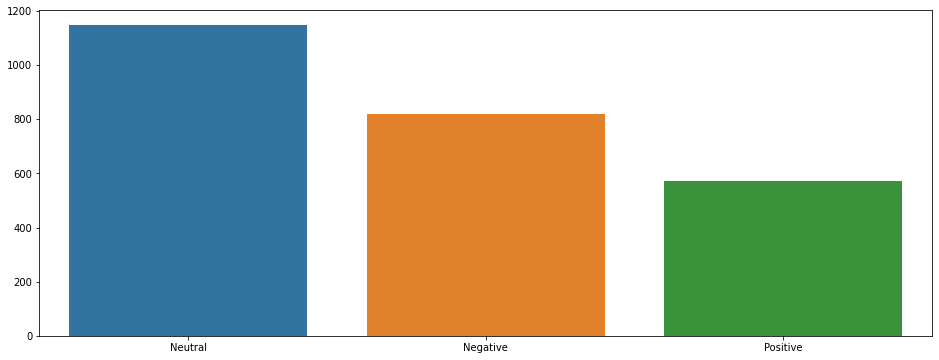

In [17]:
# Grouped Barplot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
val=[1148, 819, 573]
senti = ['Neutral', 'Negative', 'Positive']
sns.barplot(x=senti, y=val, data=df)